<a href="https://colab.research.google.com/github/radhikabhakta10/Home-Credit-Default-Risk-Project/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis (EDA)

Spencer Brothers (STAR Analytics)

IS-6813 Spring 2025 - MSBA Capstone

# Introduction

The purpose of this notebook is to gain a deeper understanding of the data and how it can be used to address the business problem. Each section analyzing datasets will use the following structure:

- Background of the dataset, how it's used in the business

- A summary of the dataset's columns and missingness, any interesting features in the dataset

- How the dataset can be used to answer Swire's questions about cart abandonment -  identify behavioral patterns that influence cart abandonment and recovery on MyCoke360

These observations will inform how we process the data for analysis.

I will do a more in-depth analysis for the visit_plan and material data.

## Key Business Questions

1. What behavioral events or sequence of events are the strongest predictors of cart abandonment?
    - Define: Events or sequences of clicks, page visits, or time delays that most commonly lead to cart abandonment.
    - Measure: Frequency and type of events before abandonment across sessions.

2. What behaviors or conditions lead to a customer returning to complete a previously abandoned cart?
    - Define: Recovery = Completed checkout after initial cart abandonment within X days.
    - Measure: Recovery rate by user behavior / device.

3. What happens after a cart is abandoned? Does the customer order through another method or churn?
    - Define: Identify if customer orders via a different ordering method or becomes an inactive customer.
    - Measure: Abandonment-to-alternative-method conversion rate.

4. What is the financial impact of cart abandonment on total MyCoke360 revenue and product mix?
    - Define: Estimate revenue lost from abandoned carts.
    - Measure: $ value of products in abandoned carts vs. total revenue, by brand/pack type.

5. Which products appear most frequently in abandoned carts?
    - Define: Identify SKUs with high frequency in abandoned carts.
    - Measure: Abandoned cart count and rate per material, by pack size/type, brand, flavor, etc.

6. How does cart abandonment vary by device type and how can it be reduced?
    - Define: Desktop vs. Mobile vs. App abandonment patterns.
    - interface.

## Important Definitions

**Plant**: Which bottling facility the customer's products will be coming from.

**Sales Office**: The location the customer orders from.

- Note: Plant and sales office are used interchangeably.

**Anchor day**: The day of week the customer must order by.

**Anchor date**: The date the customer first ordered on when their policy started. The day of week
of the anchor date is that customer’s anchor day.

**Frequency**: How often a customer orders. Usually every 1, 2, or 4 weeks.

**Cutoff time**: What time of day the customer’s order must be placed.

**Order Window**: The period between two expected orders.

## Known Data Limitations

- GA does not capture all events. This is known because some order windows in the GA data do not have a purchase event. However, there is sometimes a purchase on myCoke360 in that order window in the orders table.

- Missing purchase events is accounted for when determining abandoned carts by using the orders table.

- There is a mismatch between add to cart items in GA, GA purchase items, and items in the orders table.

- Items purchased are blank for mobile purchases.

- Limitations for Purchase Tracking:

    - Tracked cart contents do not always match the final purchased items, due to incomplete event data.
    
    - Purchase events recorded in Google Analytics do not always align with order records in the orders table.
    
    - Matching by date and account ID is unreliable, since customers sometimes place multiple orders through different channels on the same day.



# Setup

Data was provided by Swire's team and was copied to a personal drive. This notebook will mount drive in order to access that data


In [2]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# mount to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# define data folder within drive
data_location = "/content/drive/MyDrive/MSBA-Capstone-Fall-2025"

In [ ]:
# define a function that takes in a dataframe then outputs the dimensions and a count of null values in each column
def structure_nulls(df):
  print("DataFrame Dimensions:")
  print(df.shape)
  print("\nNull Value Counts per Column:")
  print(df.isnull().sum())

In [ ]:
# read in all datasets so our notebook doesn't break
GA = pd.read_csv(f'{data_location}/google_analytics.csv')
orders = pd.read_csv(f'{data_location}/orders.csv')
sales = pd.read_csv(f'{data_location}/sales.csv')
visit_plan = pd.read_csv(f'{data_location}/visit_plan.csv',
                         dtype={'FREQUENCY':'string'})
customer = pd.read_csv(f'{data_location}/customer.csv')
cutoff_times = pd.read_csv(f'{data_location}/cutoff_times.csv')
operating_hours = pd.read_csv(f'{data_location}/operating_hours.csv')
material = pd.read_csv(f'{data_location}/material.csv')

# Google Analytics

This is a fact table that fives us data on website events on myCoke360. Each row represents a specific event such as a click. It logs the time, page, associated items, etc.

In [ ]:
# view data
GA.head()

In [ ]:
# read google analytics data into a pandas dataframe
GA = pd.read_csv(f'{data_location}/google_analytics.csv')

GA.head()

In [ ]:
# looking at missing data
GA.isnull().sum()

In [ ]:
# number of rows and columns
print("Shape of the dataset:", GA.shape)
print(f"Number of rows: {GA.shape[0]}")
print(f"Number of columns: {GA.shape[1]}")

In [ ]:
# data types of each column
print("\nData types of each column:")
print(GA.dtypes)

### Missing Data Discussion

This table has about 3.7 million rows and 10 columns. In this dataset, there's structural missingness. There are null mobile brand names because a lot of activity done on desktop devices rather than mobile. The event page name and title columns also have a lot of missingness because some events, such as "user_engagement" don't have designated pages or the information of page name is present in the page title column and vice versa.

Let's investigate what events there are

In [ ]:
# describing the data (summary stats)
GA.describe(include='all').transpose()

In [ ]:
# changing time to UTC

# convert EVENT_TIMESTAMP to datetime and ensure it’s in UTC
GA['EVENT_TIMESTAMP'] = pd.to_datetime(GA['EVENT_TIMESTAMP'], utc=True)

# ensure EVENT_DATE is in UTC format:
GA['EVENT_DATE'] = pd.to_datetime(GA['EVENT_DATE'], utc=True)

# verify conversion
print(GA[['EVENT_DATE', 'EVENT_TIMESTAMP']].head())
print(GA['EVENT_TIMESTAMP'].dt.tz)

In [ ]:
# double check time conversion
GA.head()

In [ ]:
# how many event types occur overall per device cat
GA['EVENT_NAME'].value_counts()
GA.groupby('DEVICE_CATEGORY')['EVENT_NAME'].value_counts()

In [ ]:
# which device brands are most active
GA.groupby('DEVICE_CATEGORY')['EVENT_NAME'].value_counts()
GA.groupby('DEVICE_MOBILE_BRAND_NAME')['EVENT_NAME'].value_counts()

In [ ]:
# highest 5 events for each brand
device_event_counts = GA.groupby('DEVICE_CATEGORY')['EVENT_NAME'].value_counts().reset_index(name='Count')
device_event_counts.sort_values(['DEVICE_CATEGORY', 'Count'], ascending=[True, False], inplace=True)
print(device_event_counts)

In [ ]:
# top 10 events per device category
top_events = device_event_counts.groupby('DEVICE_CATEGORY').apply(lambda x: x.nlargest(10, 'Count')).reset_index(drop=True)

# Plot
plt.figure(figsize=(12,8))
sb.barplot(data=top_events, x='Count', y='EVENT_NAME', hue='DEVICE_CATEGORY')
plt.title('Top 10 Events per Device Category', fontsize=16)
plt.xlabel('Event Count')
plt.ylabel('Event Name')
plt.legend(title='Device Category')
plt.tight_layout()
plt.show()

In [ ]:
# event distribution

top_events = GA['EVENT_NAME'].value_counts().head(10)
print("\nTop 10 Event counts:\n", top_events)

# Plot
plt.figure(figsize=(10,6))
sb.barplot(x=top_events.values, y=top_events.index, palette='coolwarm')
plt.title("Top 10 Event Type Distribution")
plt.xlabel("Count")
plt.ylabel("Event Name")
plt.show()


### Summarizing GA Data

The Google Analytics dataset shows customer interaction and engagement data across different devices and event types. It includes over a million logged events, primarily from desktop users, who account for the majority of activity such as page views, button clicks, item views, and cart updates. Mobile and tablet devices also contribute, though at a smaller scale. The most frequent events are page_view (1,198,482), button_click (681,917), and view_item_list (558,466), indicating that users spend significant time browsing and interacting with products. Events like add_to_cart, update_cart, and proceed_to_checkout show strong shopping intent, while engagement events (user_engagement, screen_view) highlight ongoing user activity across sessions. Across devices, Google (desktop/Windows) and Apple (mobile/iOS) dominate usage, with smaller participation from brands like Samsung and Amazon.

# Orders

This is a fact table that gives us  what items were ordered by
which customer and when the order placed. However, orders are broken up such that each row will only have one material id. It's used to check the orders in Google Analytics (GA) data against what was actually ordered.




In [ ]:
# read orders into a pandas dataframe.
orders = pd.read_csv(f'{data_location}/orders.csv')

orders.head()

In [ ]:
orders.describe()

In [ ]:
structure_nulls(orders)

# Sales

This fact table gives us which items were sold. These items are slightly different than orders due to items being sometimes sold out. This table is used to compute revenue using NSI_DEAD_NET.

In [ ]:
display(sales.describe())

,CUSTOMER_ID,MATERIAL_ID,GROSS_PROFIT_DEAD_NET,PHYSICAL_VOLUME,NSI_DEAD_NET
count,4.997870e+05,499787.000000,499787.000000,499787.000000,499787.000000
mean,5.430889e+08,148828.482618,71.258057,6.779922,179.207562
std,4.892893e+07,75610.369930,206.914366,22.583076,565.228753
min,5.002457e+08,100722.000000,-5911.500000,1.042000,-201.600000
25%,5.012676e+08,116149.000000,16.750000,2.000000,49.350000
50%,5.016566e+08,129252.000000,32.120000,2.000000,76.680000
75%,6.000796e+08,151817.000000,58.660000,4.000000,141.000000
max,6.009753e+08,700462.000000,16797.210000,2000.000000,61614.000000


In [ ]:
sales.head()

,CUSTOMER_ID,POSTING_DATE,MATERIAL_ID,GROSS_PROFIT_DEAD_NET,PHYSICAL_VOLUME,NSI_DEAD_NET
0,600055574,7/17/2024,144775,130.68,22.0,737.00
1,600055574,7/17/2024,156082,37.42,6.0,105.42
2,501438989,7/17/2024,144775,41.84,4.0,166.40
3,600055574,7/17/2024,154914,53.24,4.0,123.88
4,600055574,7/17/2024,156182,110.30,10.0,348.80


In [ ]:
structure_nulls(sales)

DataFrame Dimensions:
(499787, 6)

Null Value Counts per Column:
CUSTOMER_ID              0
POSTING_DATE             0
MATERIAL_ID              0
GROSS_PROFIT_DEAD_NET    0
PHYSICAL_VOLUME          0
NSI_DEAD_NET             0
dtype: int64


This dataset doesn't have any nulls! Let's check for duplicates.

In [ ]:
# check duplicates
print(f"Duplicates in sales: {sales.duplicated().sum()}")

Duplicates in sales: 1997


There are 1,997 duplicate rows in the sales data. To avoid inflating the profit value, we will drop these duplicates.

In [ ]:
sales = sales.drop_duplicates()

Now that we have cleaned the sales table, let's do some exploration! First, let's join with the customers table to get some additional detail.

In [ ]:
# standardize column names
customer.columns = customer.columns.str.lower().str.replace(' ', '_')
sales.columns = sales.columns.str.lower().str.replace(' ', '_')
material.columns = material.columns.str.lower().str.replace(' ', '_') # standardize material column names

# convert posting date to datetime
sales['posting_date'] = pd.to_datetime(sales['posting_date'], errors='coerce')

# merge on customer number/id
merged = pd.merge(sales, customer, left_on='customer_id', right_on='customer_number', how='left')
merged = pd.merge(merged, material, left_on='material_id', right_on='material_id', how='left')

print("\nMerged Data Preview:")
display(merged.head())


Merged Data Preview:


,customer_id,posting_date,material_id,gross_profit_dead_net,physical_volume,nsi_dead_net,sales_office,customer_number,sales_office_description,distribution_mode_description,shipping_conditions_description,cold_drink_channel_description,customer_sub_trade_channel_description,pack_type_desc,trade_mark_desc,flavour_desc,pack_size_desc,bev_cat_desc
0,600055574,2024-07-17,144775,130.68,22.0,737.00,G111,600055574,"Draper, UT",Bulk Distribution,48 Hours,Distributor,Food Distributor,Aluminum Can,Bobby's Bottles,Matcha,16 OZ,ENERGY DRINKS
1,600055574,2024-07-17,156082,37.42,6.0,105.42,G111,600055574,"Draper, UT",Bulk Distribution,48 Hours,Distributor,Food Distributor,Plastic Bottle - Other,Pete's Popcorn,Dragonfruit,20 OZ,ENHANCED WATER BEVERAGES
2,501438989,2024-07-17,144775,41.84,4.0,166.40,G142,501438989,"Pocatello, ID",Sideload,48 Hours,Restaurant,Dining,Aluminum Can,Bobby's Bottles,Matcha,16 OZ,ENERGY DRINKS
3,600055574,2024-07-17,154914,53.24,4.0,123.88,G111,600055574,"Draper, UT",Bulk Distribution,48 Hours,Distributor,Food Distributor,Plastic Bottle - Other,Sam's,Raspberry Lime,12 OZ,JUICES/NECTARS
4,600055574,2024-07-17,156182,110.30,10.0,348.80,G111,600055574,"Draper, UT",Bulk Distribution,48 Hours,Distributor,Food Distributor,Plastic Bottle - Other,Fizz Factory,Grape,14 OZ,DAIRY/SOY BEVERAGES


Now that we have a merged data set, let's look at profits by sales office.

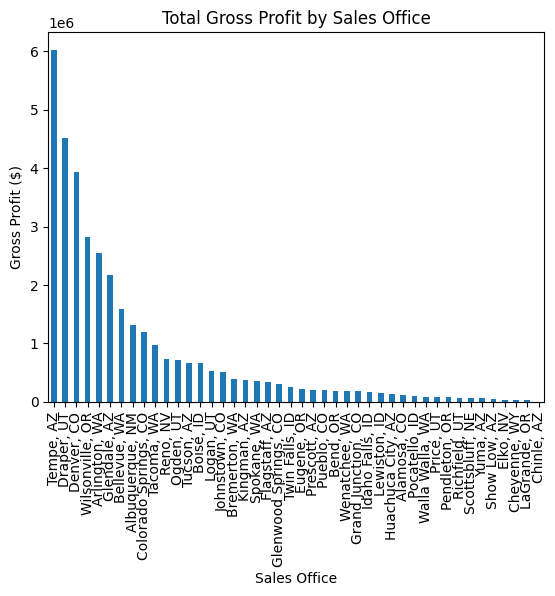

In [ ]:
# sales by office
sales_by_office = merged.groupby('sales_office_description')['gross_profit_dead_net'].sum().sort_values(ascending=False)
sales_by_office.plot(kind='bar', title='Total Gross Profit by Sales Office')
plt.ylabel('Gross Profit ($)')
plt.xlabel('Sales Office')
plt.show()

From the graph we can see the top three sales offices are Tempe, Draper and Denver!

Now let's look at profits by distribution mode and shipping method.

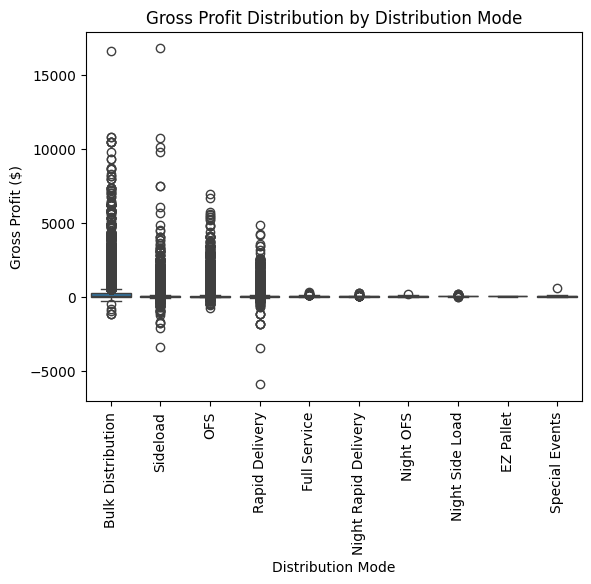

In [ ]:
# profit by distribution method
sns.boxplot(data=merged, x='distribution_mode_description', y='gross_profit_dead_net')
plt.title('Gross Profit Distribution by Distribution Mode')
plt.xlabel('Distribution Mode')
plt.ylabel('Gross Profit ($)')
plt.xticks(rotation=90)
plt.show()

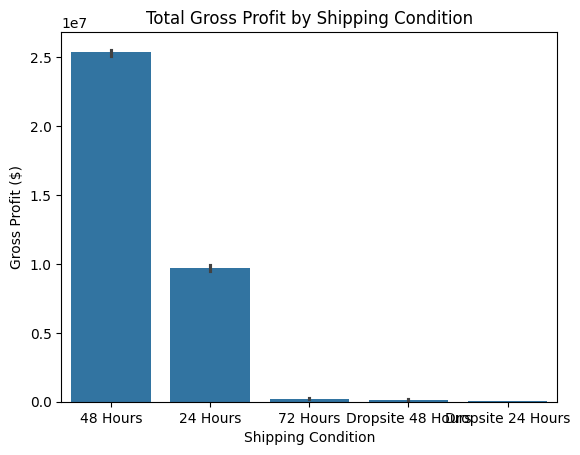

In [ ]:
# profit by shipping method
sns.barplot(data=merged, x='shipping_conditions_description', y='gross_profit_dead_net', estimator=sum)
plt.title('Total Gross Profit by Shipping Condition')
plt.xlabel('Shipping Condition')
plt.ylabel('Gross Profit ($)')
plt.show()

Although these last two graphs seem to give us little insight, we believe that shipping method and distribution mode may have an impact on customer behavior for cart abandonement so we will keep them in.

# Customer

This dimension table  gives us information on customers such as where they order from and what type of customer category they are in (restaurant,
wholesaler)

In [ ]:
customer.head()

,sales_office,customer_number,sales_office_description,distribution_mode_description,shipping_conditions_description,cold_drink_channel_description,customer_sub_trade_channel_description
0,G111,500964906,"Draper, UT",Sideload,48 Hours,Restaurant,Dining
1,G111,501543906,"Draper, UT",Sideload,48 Hours,Restaurant,Mexican Fast Food
2,G293,501394111,"Tacoma, WA",OFS,24 Hours,Attraction,Recreation Center
3,G238,501528559,"Colorado Springs, CO",OFS,48 Hours,Attraction,Recreation Center
4,G132,500504789,"Alamosa, CO",OFS,48 Hours,Restaurant,Fast Food


In [ ]:
structure_nulls(customer)

print(f"\nDuplicates in customers: {customer.duplicated().sum()}")

DataFrame Dimensions:
(6334, 7)

Null Value Counts per Column:
sales_office                              0
customer_number                           0
sales_office_description                  0
distribution_mode_description             4
shipping_conditions_description           0
cold_drink_channel_description            0
customer_sub_trade_channel_description    0
dtype: int64

Duplicates in customers: 0


No nulls or duplicates!

We will use the merged sales and customers table to continuing our analysis. We will start by looking at the top 10 customer types by total profits.

In [ ]:
# top 10 customer types by total profits
segment_summary = merged.groupby('customer_sub_trade_channel_description')['gross_profit_dead_net'].agg(['count','sum','mean']).sort_values(by='sum', ascending=False)
display(segment_summary[1:10])

,count,sum,mean
customer_sub_trade_channel_description,,,
Local Convenience,91651,2574084.80,28.085725
Wholesaler,5027,1894745.94,376.913853
Recreation Center,28981,1863301.79,64.293909
General Store,16101,1621615.17,100.715184
Restaurant,23789,1480718.00,62.243810
Dining,24181,1298223.58,53.687754
Healthcare Facility,30219,971287.39,32.141613
Motel,20125,951051.56,47.257220
Mexican Fast Food,11017,705512.13,64.038498


We can see that local convenience stores have the highest total profits! Let's look at total orders and average profits as well.

In [ ]:
# top 10 customer types by total orders
segment_summary = merged.groupby('customer_sub_trade_channel_description')['gross_profit_dead_net'].agg(['count','sum','mean']).sort_values(by='count', ascending=False)
display(segment_summary[1:10])

,count,sum,mean
customer_sub_trade_channel_description,,,
Local Convenience,91651,2574084.80,28.085725
Healthcare Facility,30219,971287.39,32.141613
Recreation Center,28981,1863301.79,64.293909
Dining,24181,1298223.58,53.687754
Restaurant,23789,1480718.00,62.243810
Motel,20125,951051.56,47.257220
Convenience Store,19341,554200.59,28.654185
General Store,16101,1621615.17,100.715184
Supermarket,12965,499920.58,38.559243


Local convenience stores still lead in total orders!

In [ ]:
# top 10 customer types by mean profits
segment_summary = merged.groupby('customer_sub_trade_channel_description')['gross_profit_dead_net'].agg(['count','sum','mean']).sort_values(by='mean', ascending=False)
display(segment_summary[1:10])

,count,sum,mean
customer_sub_trade_channel_description,,,
Distributor,208,110025.76,528.970000
Wholesaler,5027,1894745.94,376.913853
Wholesale Market,820,238593.28,290.967415
Theme Park,572,87316.29,152.650857
Middle School,4,606.37,151.592500
Religious Institution,1576,219422.35,139.227379
Food Distributor,99166,13789592.92,139.055653
Sports Arena,2876,386355.84,134.337914
Amusement Center,914,114907.58,125.719453


When we look at average profits, we see distributors jump to the #1 spot.

This table gives us a good sense of our customer base. Once we define an abondaned cart, we will be able to use the descriptive variables in this table to help us build a profile around what kind of customer will abandoned their cart.

# Visit Plan

This dimension table describes visit plans. A visit plan is on which day of the week and how often a customer is scheduled to place an order. These visit plans do change. This table gives us the historical visit plans for each customer. The day of the week of the anchor date is the customer’s day they must order by.

In [ ]:
# read visit plan data into a dataframe
visit_plan = pd.read_csv(f'{data_location}/visit_plan.csv', dtype={'FREQUENCY':'string'})

visit_plan.head()

Let's first examine the datatypes, structure, and missingness of each column.

In [ ]:
structure_nulls(visit_plan)

In [ ]:
visit_plan.dtypes

Interestingly, there are many null values in the frequency column, which will be important to our analysis.

Let's explore the frequency column more in depth so we can calculate cutoff datetimes later on.

In [ ]:
visit_plan['FREQUENCY'].value_counts(dropna=False)

It looks like when the frequency column has a description like "Every {n}th week" the frequency will just be n. To calculate the cutoff dates, we'll need to create a mapping table then apply the mapping to the frequency table.

If the frequency is "not applicable" we wont be able to calculate the cutoff times for carts.

### Exploring where frequency is not applicable

In [ ]:
visit_plan[visit_plan['FREQUENCY'] == "Not Applicable"].describe(exclude='number')

In [ ]:
# find which customer ids have "not applicable" as a frequency and see if they have any other values of frequency
visit_plan[visit_plan['FREQUENCY'] == "Not Applicable"]['CUSTOMER_ID'].value_counts()

It seems there are only two customers where the frequency is not applicable. do these customers bring in a lot of profit?

In [ ]:
# find how much these customers contribute to total profits.
sum(
    sales[sales['CUSTOMER_ID'].isin([600565083, 500714888])]['NSI_DEAD_NET']
)/sum(sales['NSI_DEAD_NET']) * 100

These two customers make up less than 0.003% of net profit, so there shouldn't be any issue in removing these customers from our analysis.

Now, let's explore where the frequency is null.

### Exploring where frequendy is null

In [ ]:
visit_plan[visit_plan['FREQUENCY'].isnull()].describe(exclude='number')

In [ ]:
# find which customer ids have null frequency
visit_plan[visit_plan['FREQUENCY'].isnull()]['CUSTOMER_ID'].value_counts()

Let's see if the Operating hours table has the information we need

In [ ]:
# join to operating_hours to see which customers still doon't have a frequency
full = visit_plan[visit_plan['FREQUENCY'].isnull()].merge(
    operating_hours,
    left_on='CUSTOMER_ID',
    right_on='CUSTOMER_NUMBER',
    how='left'
)
full.head()

In [ ]:
structure_nulls(full)


There *is* more information on order frequency in the operating hours table. While this information may not be perfect, its better than nothing.

Let's see which of these customers still don't have any visit plan information:

In [ ]:
# find which customers still don't have any frequency information in the joined data
full[full['FREQUENCY_y'].isnull()]['CUSTOMER_ID'].unique()

There are 11 customers where we have no visit plan information. Let's see how much revenue these customers bring in.

In [ ]:
# determine the percentage of sales that these customers contribute
sales[sales['CUSTOMER_ID'].isin(
    full[full['FREQUENCY_y'].isnull()]['CUSTOMER_ID'].unique()
    )]['NSI_DEAD_NET'].sum() / sum(sales['NSI_DEAD_NET']) * 100

These customers make up less than 0.07% of profit, so we can probably exclude these customers as well.

### Dropping customers with no visit plans and filling null frequencies and anchor dates.

In [ ]:
# define list of customer id's to exclude
cust_exclude = [
    600565083, 500714888, 501652104, 501653011, 500312987, 501226870, 500995978, 501654391, 501585173, 501297027, 501364983, 600581129, 501202498
]

# drop these customers from the visit plan table
visit_plan = visit_plan[~visit_plan['CUSTOMER_ID'].isin(cust_exclude)]

# join the visit plan with the operating hours table to get our best estimate of FREQUENCY and ANCHOR_DATE
visit_plan = visit_plan.merge(
    operating_hours,
    left_on='CUSTOMER_ID',
    right_on='CUSTOMER_NUMBER',
    how='left'
)

# fill the null values in FREQUENCY_x and ANCHOR_DATE with the values in FREQUENCY_y and CALLING_ANCHOR_DATE
visit_plan['FREQUENCY_x'] = visit_plan['FREQUENCY_x'].fillna(visit_plan['FREQUENCY_y'])
visit_plan['ANCHOR_DATE'] = visit_plan['ANCHOR_DATE'].fillna(visit_plan['CALLING_ANCHOR_DATE'])

# rename the FREQUENCY_x column to FREQUENCY
visit_plan = visit_plan.rename(columns={'FREQUENCY_x': 'FREQUENCY'})

# drop the remaining columns that weren't originally in the visit plan table
visit_plan = visit_plan.drop(columns=['CUSTOMER_NUMBER', 'FREQUENCY_y', 'DELIVERY_ANCHOR_DAY', 'CALLING_ANCHOR_DATE'])

structure_nulls(visit_plan)

That looks much better. We can address the missing sales office/distribution modes if the need arises.

### Mapping frequencies

In [ ]:
# determine which values in the frequency column need to be mapped to integers
visit_plan['FREQUENCY'].unique()

In [ ]:
# map values in the frequency column to integers so we can calculate whether carts are abandoned.
frequency_mapping = {
     '02':2, '01':1, '04':4, 'Every Second Week On':2,
     'Every Week On':1, 'Every Fourth Week On':4,
     'Every Third Week On':3, 'Every Tenth Week On':10, '03':3,
     'Every Fifth Week On':5, 'Every Eighth Week On':8,
     'Every 4 Weeks':4, 'Every Sixth Week On':6, 'Every 2 Weeks':2,
     'Every Week':1, '1 ':1, '2 ':2, '4 ':4, '3 ':3, '10':10, '05':5,
     '5 ':5, '8 ':8, '08':8, '06':6
}

visit_plan['FREQUENCY'] = visit_plan['FREQUENCY'].map(frequency_mapping)

visit_plan['FREQUENCY'].value_counts(dropna=False)

We can see that weekly frequencies are most common, followed by bi-weekly frequencies.

# Order Cut Off Times

Each sales office has a specific time of day its
customers must have their order in by. The
default time is 5pm but there are exceptions.
This table lists all the exceptions. Use sales
office, shipping conditions and distribution
mode to join to visit plan table

In [3]:
# read in cutoff times data into a pandas dataframe
cutoff_times = pd.read_csv(f'{data_location}/cutoff_times.csv')

cutoff_times.head()

NameError: name 'data_location' is not defined

In [ ]:
# show the structure and missingness of the data
structure_nulls(cutoff_times)

In [ ]:
# number of rows and columns
print("Shape of the dataset:", cutoff_times.shape)
print(f"Number of rows: {cutoff_times.shape[0]}")
print(f"Number of columns: {cutoff_times.shape[1]}")

In [ ]:
# data types of each column
print("\nData types of each column:")
print(cutoff_times.dtypes)

In [ ]:
# describing the data (summary stats)
cutoff_times.describe(include='all').transpose()

In [ ]:
# datatype and non-null count info
cutoff_times.info()

In [ ]:
# parse times (assuming they're in local time, e.g., US/Mountain)
cutoff_times['CUTOFFTIME__C'] = pd.to_datetime(cutoff_times['CUTOFFTIME__C'], format='%I:%M:%S %p')

# add a date to make them valid datetimes (optional, if needed)
cutoff_times['CUTOFFTIME__C'] = cutoff_times['CUTOFFTIME__C'].apply(lambda x: x.replace(year=2025, month=1, day=1))

# localize to Mountain Time (for Draper, UT) and convert to UTC
cutoff_times['CUTOFFTIME_UTC'] = (
    cutoff_times['CUTOFFTIME__C']
    .dt.tz_localize('US/Mountain', ambiguous='NaT')
    .dt.tz_convert('UTC')
)

print(cutoff_times[['CUTOFFTIME__C', 'CUTOFFTIME_UTC']])

In [ ]:
# double check data
cutoff_times.head()

In [ ]:
# distribution of cutoff times (in UTC)
plt.figure(figsize=(10,5))
sb.histplot(cutoff_times['CUTOFFTIME_UTC'].dt.hour, bins=24, kde=True, color='skyblue')
plt.title("Distribution of Cutoff Times (by Hour, UTC)")
plt.xlabel("Hour of Day (UTC)")
plt.ylabel("Number of Plants/Sales Offices")
plt.show()

In [ ]:
# average cutoff time by sales office

# convert cutoff times to hours for easier averaging
cutoff_times['CUTOFF_HOUR_UTC'] = cutoff_times['CUTOFFTIME_UTC'].dt.hour + cutoff_times['CUTOFFTIME_UTC'].dt.minute/60

avg_cutoff_by_office = cutoff_times.groupby('SALES_OFFICE')['CUTOFF_HOUR_UTC'].mean().sort_values()

plt.figure(figsize=(10,6))
sb.barplot(x=avg_cutoff_by_office.values, y=avg_cutoff_by_office.index, palette='coolwarm')
plt.title("Average Cutoff Time by Sales Office (UTC Hours)")
plt.xlabel("Average Cutoff Hour (UTC)")
plt.ylabel("Sales Office")
plt.show()

### Summary of Cutoff

The dataset contains 220 records with 17 unique cutoff times, indicating varying order processing deadlines across sales offices and plants. The most common cutoff time is 3:00 PM, occurring 36 times, suggesting it may serve as the company’s standard or default shipping deadline. These variations in cutoff times likely reflect operational differences between locations or distribution modes, helping ensure timely deliveries based on regional schedules and logistics capacities. The first graph shows that the distribution of cutoff time is skewed towards the end of the day. This makes sense as the most cutoff times are from the range of 15:00-23:00. The second graph indicates that Logan, UT has the shortest cutoff time while Prescott, AZ has that longest cutoff time.

# Operating Hours

This table has similar information as the visit
plan table, but it has the current information
for the customers.

In [ ]:
# read in operating hours to a pandas dataframe
operating_hours = pd.read_csv(f'{data_location}/operating_hours.csv')

operating_hours.head()

In [ ]:
# show the structure and missingness of the data
structure_nulls(operating_hours)

In [ ]:
operating_hours['CALLING_ANCHOR_DATE'].describe()

# Material

This table gives us specific information on
products. For each material id we have the
category, brand, flavor, pack size & type.

In [ ]:
# read in material data to a pandas dataframe
material = pd.read_csv(f'{data_location}/material.csv')

material.head()

In [ ]:
# show structure and missingness of data
structure_nulls(material)

In [ ]:
print(list(material[material['BEV_CAT_DESC'].isnull()]['TRADE_MARK_DESC'].unique()))

print(list(material[material['TRADE_MARK_DESC'] == 'Sunny Sip']['BEV_CAT_DESC'].value_counts()))

The null `BEV_CAT_DESC` values seem to be Sunny Sip products, and all Sunny Sip products have null `BEV_CAT_DESC`.

This table will be valuable when analyzing what products may be more likely to appear in abandoned shopping carts.